#### Exploratory Data Analysis

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2


##### General overview

In [25]:
train_df = pd.read_csv("data/original_data/ais_train.csv", sep="|")

train_df.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3


In [14]:
train_df.dtypes

time          object
cog          float64
sog          float64
rot            int64
heading        int64
navstat        int64
etaRaw        object
latitude     float64
longitude    float64
vesselId      object
portId        object
dtype: object

In [15]:
train_df.describe()

,cog,sog,rot,heading,navstat,latitude,longitude
count,1.522065e+06,1.522065e+06,1.522065e+06,1.522065e+06,1.522065e+06,1.522065e+06,1.522065e+06
mean,1.782494e+02,6.331703e+00,5.054561e-01,1.762737e+02,2.092604e+00,3.658497e+01,1.153646e+01
std,1.076785e+02,7.539364e+00,1.760916e+01,1.070860e+02,2.411965e+00,2.290488e+01,6.871572e+01
min,0.000000e+00,0.000000e+00,-1.270000e+02,0.000000e+00,0.000000e+00,-4.753287e+01,-1.675409e+02
25%,7.820000e+01,0.000000e+00,0.000000e+00,7.500000e+01,0.000000e+00,3.451683e+01,-5.212810e+00
50%,1.838000e+02,5.000000e-01,0.000000e+00,1.800000e+02,0.000000e+00,4.223370e+01,4.234350e+00
75%,2.690000e+02,1.410000e+01,0.000000e+00,2.650000e+02,5.000000e+00,5.135197e+01,1.883715e+01
max,3.600000e+02,1.023000e+02,1.280000e+02,5.110000e+02,1.500000e+01,7.055720e+01,1.788054e+02


In [21]:
train_df.describe(include="object")

,time,etaRaw,vesselId,portId
count,1522065,1522065,1522065,1520450
unique,947226,9874,688,772
top,2024-04-25 03:59:44,02-04 15:00,6323f2287abc89c0a9631e57,61d36f9a0a1807568ff9a156
freq,19,3319,8656,84383


In [22]:
train_df.isnull().sum()

time            0
cog             0
sog             0
rot             0
heading         0
navstat         0
etaRaw          0
latitude        0
longitude       0
vesselId        0
portId       1615
dtype: int64

In [28]:
train_df_copy = pd.DataFrame(train_df)

train_df_copy['time_converted'] = pd.to_datetime(train_df_copy['time'], errors='coerce')

duplicates = train_df_copy[train_df_copy.duplicated(subset=['vesselId', 'time_converted'])]

print(duplicates.count())

time              0
cog               0
sog               0
rot               0
heading           0
navstat           0
etaRaw            0
latitude          0
longitude         0
vesselId          0
portId            0
time_converted    0
dtype: int64


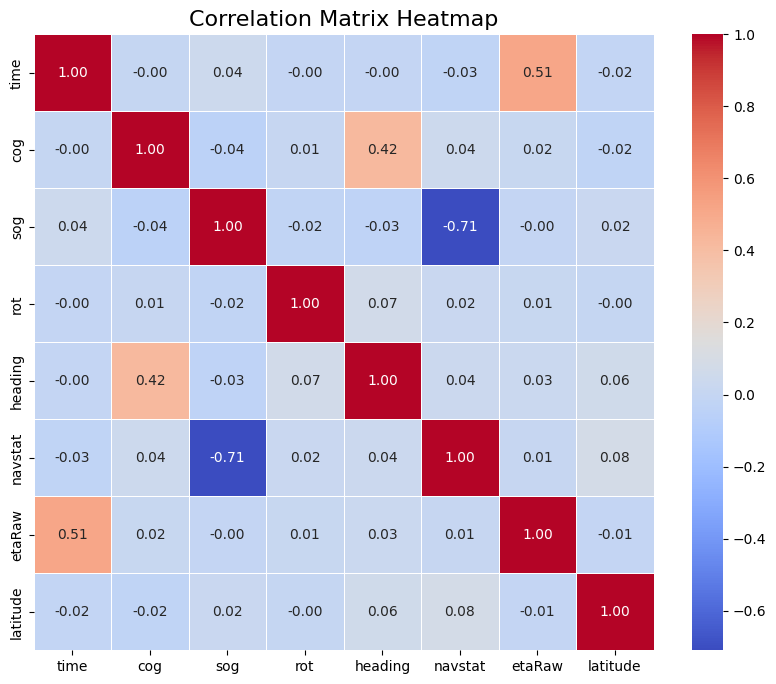

In [29]:
train_df_copy = pd.DataFrame(train_df)


reference_time = pd.to_datetime("2024-01-01 00:00:00")

train_df_copy['time_converted'] = pd.to_datetime(train_df_copy['time'], errors='coerce')
train_df_copy['time'] = (train_df_copy['time_converted'] - reference_time).dt.total_seconds()
train_df_copy.drop(['time_converted'], axis=1, inplace=True)

train_df_copy['eta_converted'] = pd.to_datetime('2024' + '-' + train_df_copy['etaRaw'], format='%Y-%m-%d %H:%M', errors='coerce')
train_df_copy['etaRaw'] = (train_df_copy['eta_converted'] - reference_time).dt.total_seconds()
train_df_copy.drop(['eta_converted'], axis=1, inplace=True)

correlation_matrix = train_df_copy[['time', 'cog', 'sog', 'rot', 'heading', 'navstat', 'etaRaw', 'latitude']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add title and labels
plt.title('Correlation Matrix Heatmap', size=16)
plt.show()

##### Time feature

The timestamp that a measurement was taken.

Ideas:

The feature values need to be transformed to a numerical value that a machine learning model can understand.

- Transform the feature into one linear feature based on how much time has passed from the starting date <-- I think this one would work best
- Separate the feature into several features denoting day, month etc.

In [26]:
train_df["time"].head()

0    2024-01-01 00:00:25
1    2024-01-01 00:00:36
2    2024-01-01 00:01:45
3    2024-01-01 00:03:11
4    2024-01-01 00:03:51
Name: time, dtype: object

In [31]:
max_time = train_df["time"].max()
min_time = train_df["time"].min()
time_count = train_df["time"].count()
time_unique_values_count = len(train_df["time"].unique())

time_converted_df = pd.DataFrame()
time_converted_df['time_converted'] = pd.to_datetime(train_df['time'], errors='coerce')
invalid_timestamps = time_converted_df['time_converted'].isna().sum()

print(f"Max time: {max_time}")
print(f"Min time: {min_time}")
print(f"Count: {time_count}")
print(f"Unique time values: {time_unique_values_count}")
print(f"Count of invalid timestamps: {invalid_timestamps}")




Max time: 2024-05-07 23:59:08
Min time: 2024-01-01 00:00:25
Count: 1522065
Unique time values: 947226
Count of invalid timestamps: 0


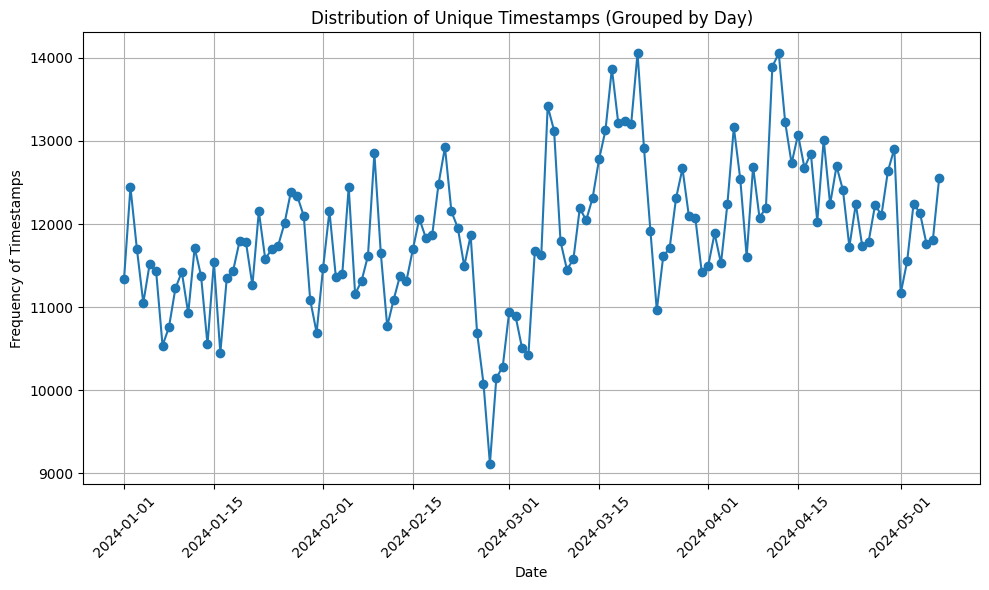

In [34]:
timestamp_distribution = time_converted_df['time_converted'].dt.floor('D').value_counts().sort_index()

plt.figure(figsize=(10,6))
plt.plot(timestamp_distribution.index, timestamp_distribution.values, linestyle='-', marker='o')
plt.title("Distribution of Unique Timestamps (Grouped by Day)")
plt.xlabel("Date")
plt.ylabel("Frequency of Timestamps")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

##### COG feature (Course Over Ground)

Shows the true trajectory of the vessel, taking into account wind and current. Measured in degrees from 0 to 360.

Default value is 360, meaning that cog was not available for the specific vessel at that timestamp.

Ideas:

- Replace default COG value (360) with an approximation based on Heading
- If Heading is not available, expraploate based on last known COG and perhaps next known COG

In [35]:
train_df["cog"].head()

0    284.0
1    109.6
2    111.0
3     96.4
4    214.0
Name: cog, dtype: float64

In [41]:
max_cog = train_df["cog"].max()
min_cog = train_df["cog"].min()
cog_count = train_df["cog"].count()
cog_unique_values_count = len(train_df["cog"].unique())
cog_default_value_count = len(train_df[train_df["cog"] == 360.0])

print(f"Max cog: {max_cog}")
print(f"Min cog: {min_cog}")
print(f"Count: {cog_count}")
print(f"Unique cog values: {cog_unique_values_count}")
print(f"Default cog value count: {cog_default_value_count}")


Max cog: 360.0
Min cog: 0.0
Count: 1522065
Unique cog values: 3601
Default cog value count: 5858


Chosen vessel ID: 61e9f440b937134a3c4c017d
['61e9f440b937134a3c4c017d']
time              2086
cog               2086
sog               2086
rot               2086
heading           2086
navstat           2086
etaRaw            2086
latitude          2086
longitude         2086
vesselId          2086
portId            2086
time_converted    2086
dtype: int64


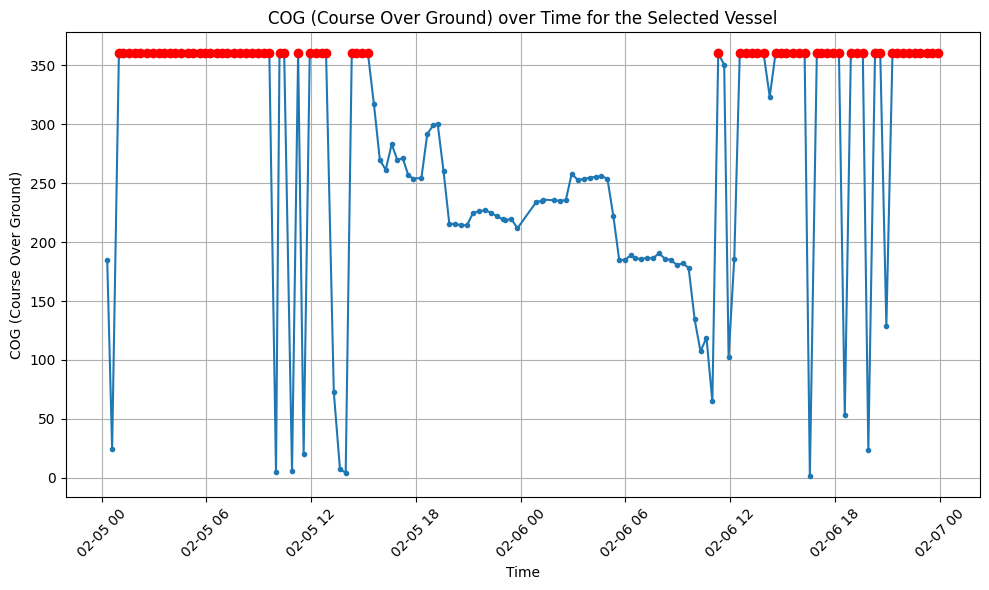

In [72]:
df_for_first_vessel = pd.DataFrame(train_df)

df_cog_360 = df_for_first_vessel[df_for_first_vessel['cog'] == 360.0]

vessel_id = df_cog_360.iloc[0,9]
print(f"Chosen vessel ID: {vessel_id}")

df_for_first_vessel = df_for_first_vessel[df_for_first_vessel["vesselId"] == vessel_id]

print(df_for_first_vessel["vesselId"].unique())

df_for_first_vessel['time_converted'] = pd.to_datetime(df_for_first_vessel['time'], errors='coerce')

print(df_for_first_vessel[df_for_first_vessel['cog'] == 360.0].count())
df_for_first_vessel_filtered = df_for_first_vessel[(df_for_first_vessel['time_converted'] < pd.to_datetime("2024-02-07")) & (df_for_first_vessel['time_converted'] > pd.to_datetime("2024-02-5"))]


df_red_points = df_for_first_vessel_filtered[df_for_first_vessel_filtered['cog'] == 360.0]

plt.figure(figsize=(10, 6))
plt.plot(df_for_first_vessel_filtered['time_converted'], df_for_first_vessel_filtered['cog'], marker='o', linestyle='-', markersize=3)
plt.scatter(df_red_points['time_converted'], df_red_points['cog'], color='red', label='COG = 360.0', zorder=5)


plt.title('COG (Course Over Ground) over Time for the Selected Vessel')
plt.xlabel('Time')
plt.ylabel('COG (Course Over Ground)')
plt.xticks(rotation=45) 
plt.grid(True)

plt.tight_layout()
plt.show()


##### Heading feature

The direction of which the bow of the given vessel is pointing at the exact timestep, measured in degrees from 0 to 360.

Not influenced by drift, in contrast to COG. Default value is 511, indicating that heading was not available.

Ideas:

Need to insert value for heading where it is set to either 511 or 483 (default values indicating the heading could not be read)
- In instances where heading is missing but not COG -> Infer heading from COG (maybe not, these features do not seem to correlate massively)
- In instances where both heading and COG are missing -> Extrapolate 

In [73]:
train_df["heading"].head()

0     88
1    347
2    112
3    142
4    215
Name: heading, dtype: int64

In [93]:
max_heading = train_df[train_df["heading"] != 511]["heading"].max()
min_heading = train_df["heading"].min()
heading_count = train_df["heading"].count()
heading_unique_values_count = len(train_df["heading"].unique())

headings_above_max_heading = train_df[train_df["heading"] > 359]
unique_headings_above_max_heading = headings_above_max_heading["heading"].unique()
heading_values_above_max_count = len(headings_above_max_heading)
heading_abnormal_value_count = len(train_df[train_df["heading"] == 483])

heading_default_value_count = len(train_df[train_df["heading"] == 511])

heading_default_and_cog_default_count = len(train_df[(train_df["heading"] > 359) & (train_df["cog"] == 360)])

print(f"Max heading, excluding default value: {max_heading}")
print(f"Min heading: {min_heading}")
print(f"Count: {heading_count}")
print(f"Unique heading values: {heading_unique_values_count}")
print(f"Unique heading values above max heading: {unique_headings_above_max_heading}")
print(f"Heading values above max value count: {heading_values_above_max_count}")
print(f"Default heading value count: {heading_default_value_count}")
print(f"Count of entries where heading is 483: {heading_abnormal_value_count}")
print(f"Count of entries where both heading and cog are missing: {heading_default_and_cog_default_count}")

Max heading, excluding default value: 483
Min heading: 0
Count: 1522065
Unique heading values: 362
Unique heading values above max heading: [511 483]
Heading values above max value count: 4896
Default heading value count: 4895
Count of entries where heading is 483: 1
Count of entries where both heading and cog are missing: 1081


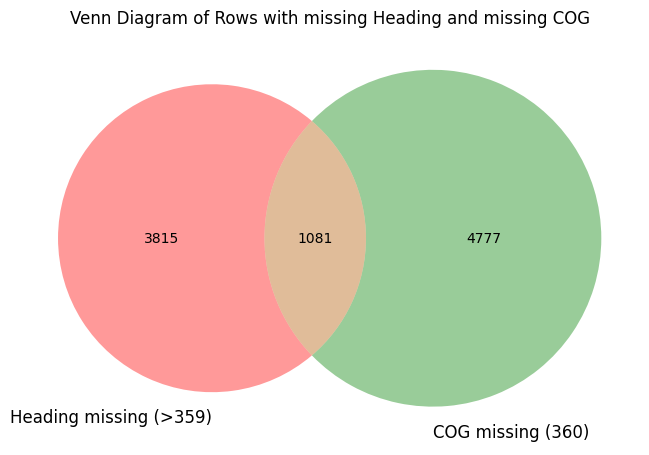

In [104]:
rows_where_heading_missing = set(train_df.index[train_df['heading'] > 359])
rows_where_cog_missing = set(train_df.index[train_df['cog'] == 360])

plt.figure(figsize=(8, 8))
venn2([rows_where_heading_missing, rows_where_cog_missing], set_labels=('Heading missing (>359)', 'COG missing (360)'))

plt.title("Venn Diagram of Rows with missing Heading and missing COG")
plt.show()

Chosen vessl ID: 61e9f3a8b937134a3c4bfdf7
['61e9f3a8b937134a3c4bfdf7']
['02-06 04:00' '02-05 06:00' '02-07 13:00']


<Figure size 1000x600 with 0 Axes>

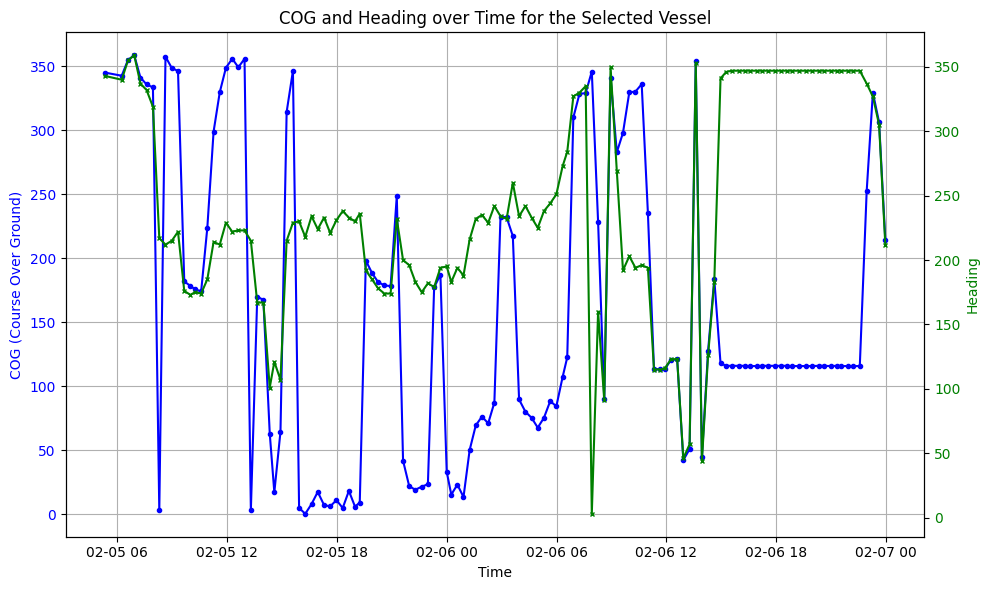

In [136]:
# Filter vessel IDs by whether they have valid heading and cog feature values in all timestamps
valid_vessel_ids = train_df.groupby('vesselId').filter(
    lambda group: (group['cog'] != 360).all() and (group['heading'] <= 359).all()
)['vesselId'].unique()

vessel_id = valid_vessel_ids[0]
print(f"Chosen vessl ID: {vessel_id}")

df_for_vessel = train_df[train_df["vesselId"] == vessel_id].copy()

print(df_for_vessel["vesselId"].unique())

df_for_vessel['time_converted'] = pd.to_datetime(df_for_vessel['time'], errors='coerce')

df_for_vessel_filtered = df_for_vessel[(df_for_vessel['time_converted'] < pd.to_datetime("2024-02-07")) & (df_for_vessel['time_converted'] > pd.to_datetime("2024-02-5"))]

plt.figure(figsize=(10, 6))
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot COG on the left y-axis
ax1.plot(df_for_vessel_filtered['time_converted'], df_for_vessel_filtered['cog'], marker='o', linestyle='-', markersize=3, color='b', label='COG')
ax1.set_xlabel('Time')
ax1.set_ylabel('COG (Course Over Ground)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Step 2: Create a second y-axis to plot Heading
ax2 = ax1.twinx()  # Instantiate a second y-axis sharing the same x-axis
ax2.plot(df_for_vessel_filtered['time_converted'], df_for_vessel_filtered['heading'], marker='x', linestyle='-', markersize=3, color='g', label='Heading')
ax2.set_ylabel('Heading', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Add title and grid
plt.title('COG and Heading over Time for the Selected Vessel')
ax1.grid(True)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()



##### SOG feature (Speed Over Ground)

The vessel's speed relative to the seafloor at the timestamp. Can be between 0 and 102.2 knots. 

102.3 = Not available, 102.2 = 102.2 knots or higher


In [147]:
max_sog = train_df["sog"].max()
max_sog_below_not_available = train_df[train_df["sog"] < 102.3]["sog"].max()
min_sog = train_df["sog"].min()
sog_count = train_df["sog"].count()
sog_unique_values_count = len(train_df["sog"].unique())

print(f"Max sog: {max_sog}")
print(f"Max sog below not available: {max_sog_below_not_available}")
print(f"Min sog: {min_sog}")
print(f"Count: {sog_count}")
print(f"Unique sog values: {sog_unique_values_count}")

Max sog: 102.3
Max sog below not available: 102.2
Min sog: 0.0
Count: 1522065
Unique sog values: 281


##### ROT feature (Rate Of Turn)

Indicates how quickly the vessel is changing its heading either to the right (positive value) or to the left (negative value)

In [149]:
max_rot = train_df["rot"].max()
max_rot_below_not_available = train_df[train_df["rot"] < 128]["rot"].max()
min_rot = train_df["rot"].min()
rot_count = train_df["rot"].count()
rot_unique_values_count = len(train_df["rot"].unique())

print(f"Max rot: {max_rot}")
print(f"Max rot below not available: {max_rot_below_not_available}")
print(f"Min rot: {min_rot}")
print(f"Count: {rot_count}")
print(f"Unique rot values: {rot_unique_values_count}")

Max rot: 128
Max rot below not available: 127
Min rot: -127
Count: 1522065
Unique rot values: 104


##### NAVSTAT feature (Navigational status)

Different navigational statuses, a categorical feature!

Unique values: [ 0  1  5 15  3  2  8 12 13  4  6 14 11  7  9]
Unique value count: 15


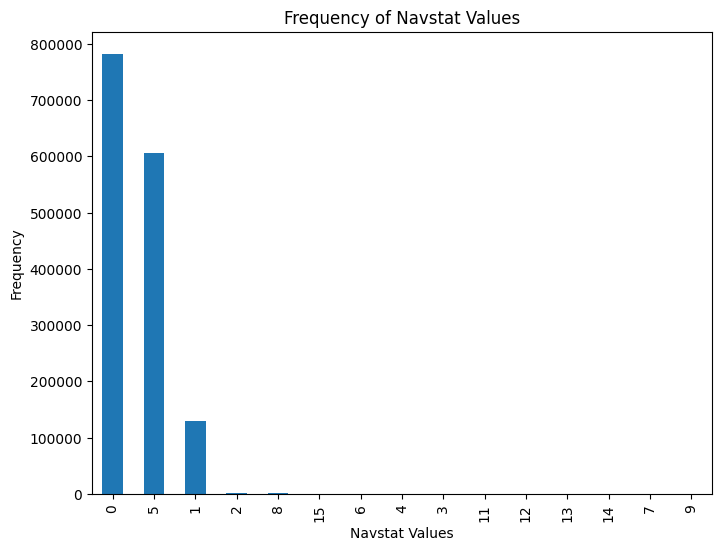

In [11]:
unique_navstats = train_df["navstat"].unique()

print(f"Unique values: {unique_navstats}")
print(f"Unique value count: {len(unique_navstats)}")

navstat_counts = train_df['navstat'].value_counts()


# Plot the barplot
plt.figure(figsize=(8, 6))
navstat_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Navstat Values')
plt.ylabel('Frequency')
plt.title('Frequency of Navstat Values')

# Show the plot
plt.show()

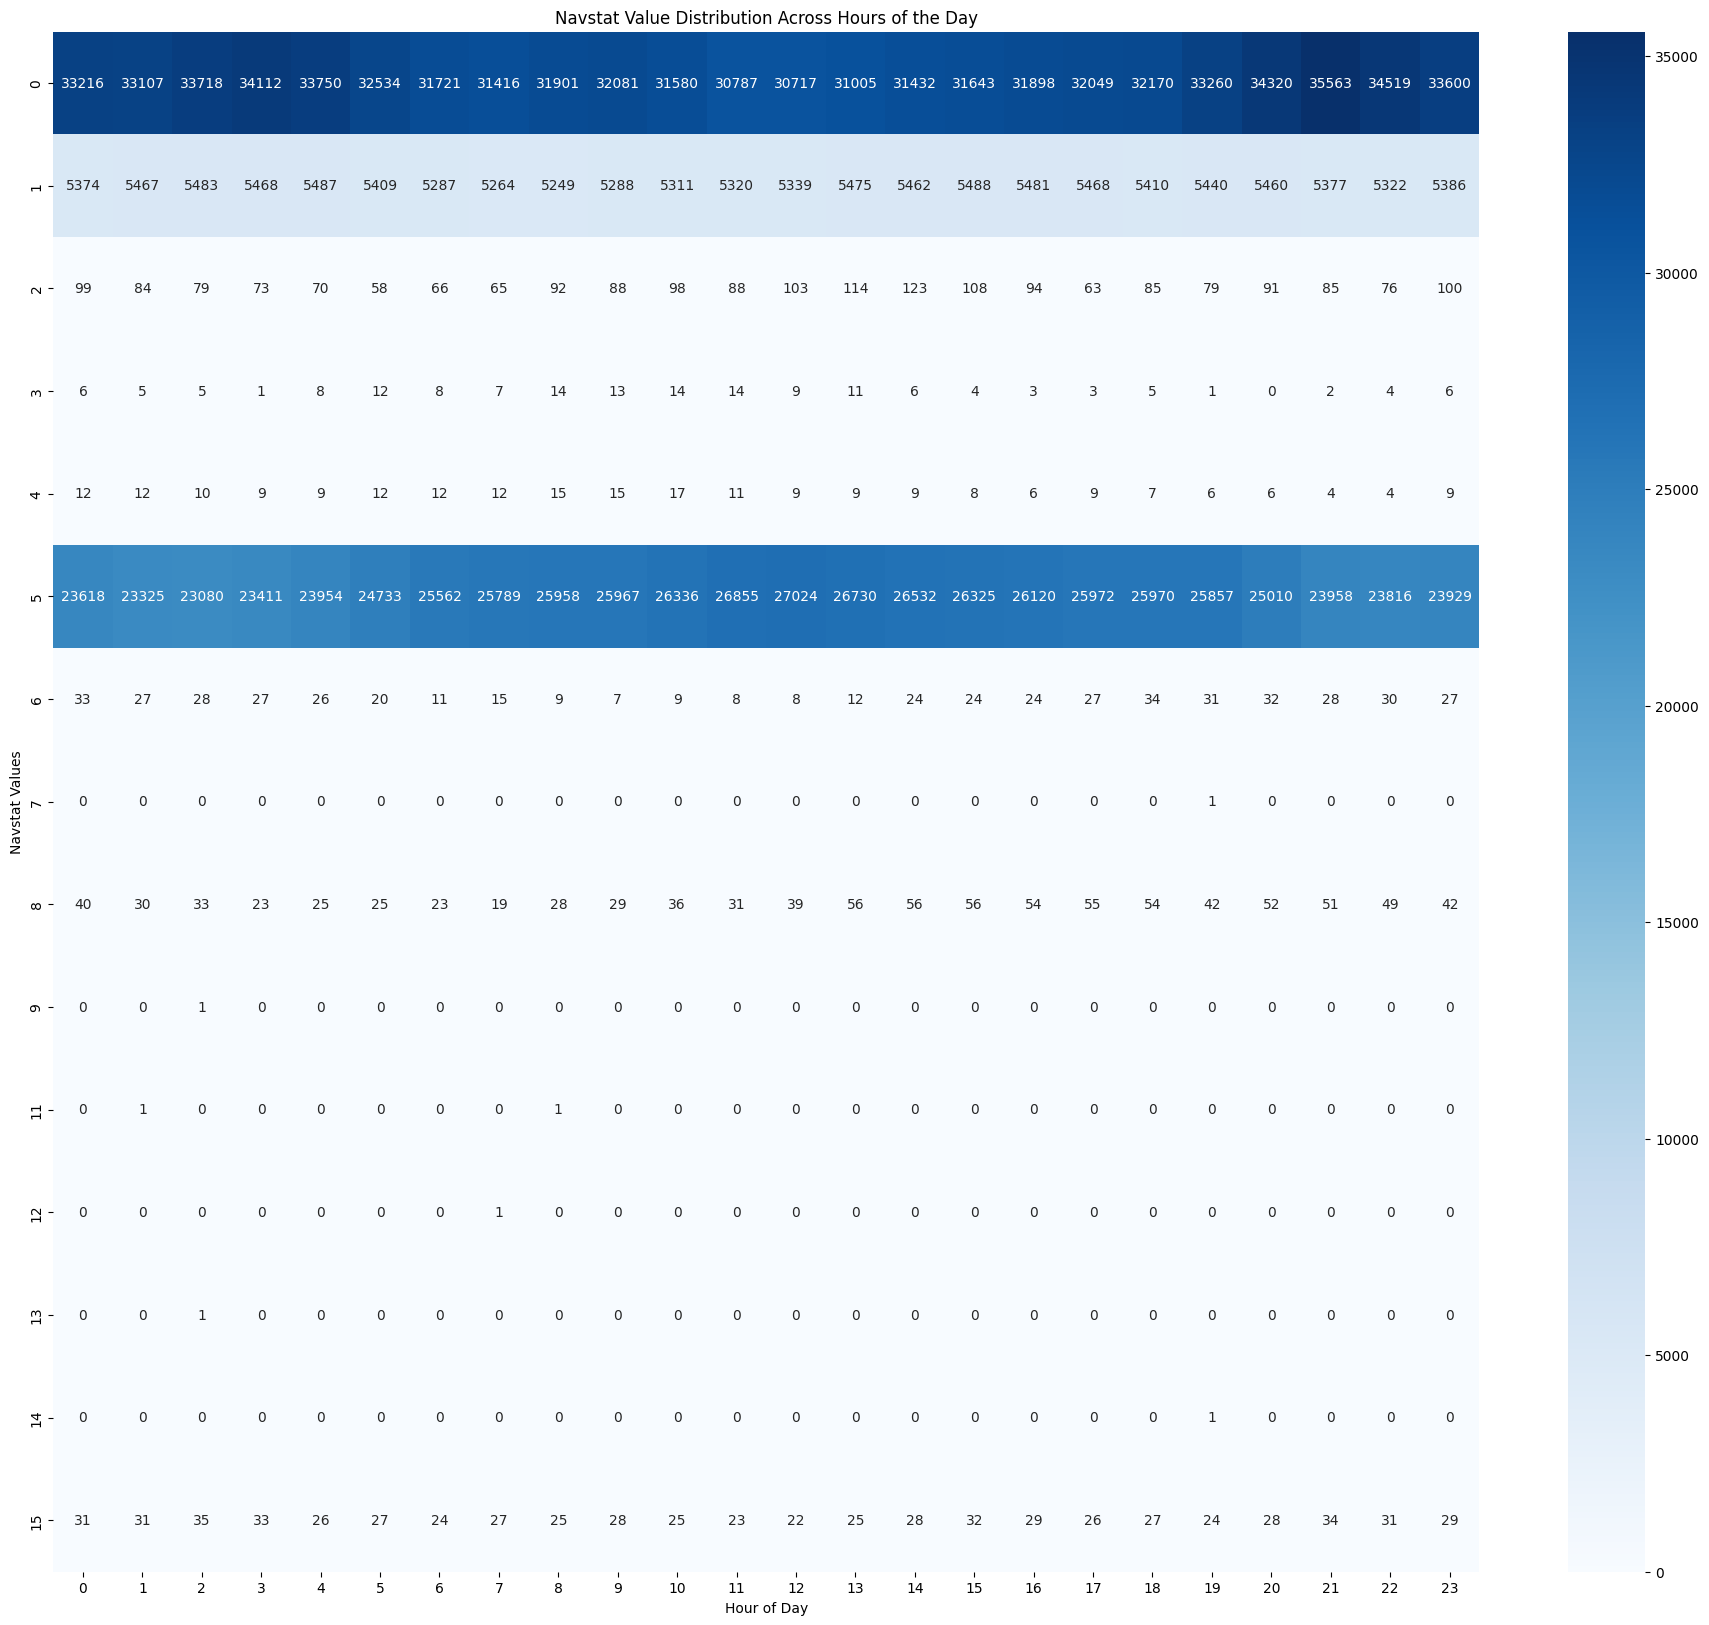

Correlation matrix:
               navstat  hour_of_day
navstat      1.000000     0.004459
hour_of_day  0.004459     1.000000


In [32]:
# Check whether there is some correlation between navstat value and time

train_df_copy = pd.DataFrame(train_df)

train_df_copy['time_converted'] = pd.to_datetime(train_df_copy['time'], errors='coerce')

# Step 2: Extract the hour of the day from the 'time_converted' column
train_df_copy['hour_of_day'] = train_df_copy['time_converted'].dt.hour

# Step 3: Group by 'navstat' and 'hour_of_day' to see frequency distribution
navstat_time_distribution = train_df_copy.groupby(['navstat', 'hour_of_day']).size().unstack(fill_value=0)

# Step 4: Plot the distribution of navstat values over the hours of the day
plt.figure(figsize=(23, 20))
sns.heatmap(navstat_time_distribution, cmap="Blues", annot=True, fmt="d")

# Add labels and title
plt.xlabel('Hour of Day')
plt.ylabel('Navstat Values')
plt.title('Navstat Value Distribution Across Hours of the Day')

plt.show()

# Optional: Correlation between navstat and hour of day using a statistical method
correlation = train_df_copy[['navstat', 'hour_of_day']].corr(method='pearson')
print("Correlation matrix:\n", correlation)

##### portID feature

In [35]:
distinct_vesselIds = train_df["vesselId"].unique()

counter = 0

for vesselId in distinct_vesselIds:
    df = train_df[train_df["vesselId"] == vesselId]
    unique_portIds = df["portId"].unique()
    if len(unique_portIds) > 1:
        counter += 1

print(f"Unique vessels with more than one port ID: {counter}/{len(distinct_vesselIds)}")

Unique vessels with more than one port ID: 684/688
